In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.6.0+cu124  Device: cuda


In [3]:
DEVICE

device(type='cuda')

In [4]:
BATCH_SIZE = 32
EPOCHS = 20

In [5]:
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [6]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


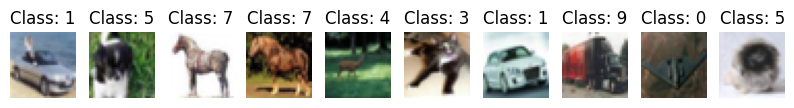

In [7]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 8 * 8 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [9]:
model = CNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [10]:
def train(model, train_loader, optimizer, log_interval):
    global output, label
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, prediction = torch.max(output, dim=1 )
        # 정답을 맞춘 갯수
        # acc += sum(idx == label)
        correct += prediction.eq(label.view_as(prediction)).sum().item()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image),
                len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

    train_loss /= (len(train_loader.dataset) / BATCH_SIZE)
    train_accuracy = 100. * correct / len(train_loader.dataset)

    return train_loss, train_accuracy

In [11]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()

    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [12]:
loss_hist_train     = [0] * EPOCHS
accuracy_hist_train = [0] * EPOCHS
loss_hist_valid     = [0] * EPOCHS
accuracy_hist_valid = [0] * EPOCHS
for epoch in range(1, EPOCHS + 1):
    loss_, acc_ = train(model, train_loader, optimizer, log_interval = 200)
    loss_hist_train[epoch-1] = loss_
    accuracy_hist_train[epoch-1] = acc_
    test_loss, test_accuracy = evaluate(model, test_loader)
    loss_hist_valid[epoch-1] = test_loss
    accuracy_hist_valid[epoch-1] = test_accuracy
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/tmp/ipython-input-8-1875207390.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.271193
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 2.043186
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.815066
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.600159
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.695589
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.604652
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.700428
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.560278

[EPOCH: 1], 	Test Loss: 1.5508, 	Test Accuracy: 43.66 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.474631
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.397208
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.550168
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.508736
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.743586
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.384827
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.487447
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.589175

[EPOCH: 2], 	Test Loss: 1.3353, 	Test Accuracy: 52.61 % 

IndexError: list assignment index out of range

In [15]:
x_arr

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

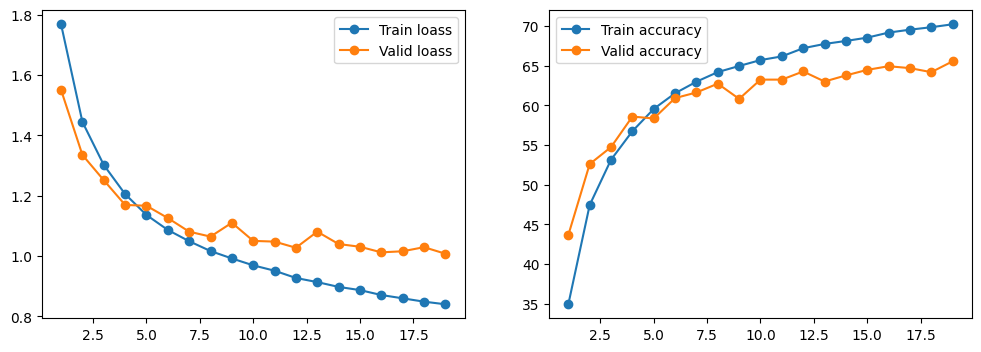

In [19]:
x_arr = np.arange(len(loss_hist_train[1:])) + 1
#accuracy_hist_train
#loss_hist_valid [1:]
#accuracy_hist_valid
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr,loss_hist_train[1:], '-o', label='Train loass' )
ax.plot(x_arr,loss_hist_valid[1:], '-o', label='Valid loass' )
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr,accuracy_hist_train[1:], '-o', label='Train accuracy' )
ax.plot(x_arr,accuracy_hist_valid[1:], '-o', label='Valid accuracy' )
ax.legend()
plt.show()